<a href="https://www.kaggle.com/code/yagizhidircan/ev-fiyat-tahmin-projesi?scriptVersionId=128575969" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Veri setimiz 79 adet değişkenli, Amerika Iowa şehrindeki ev verilerinden oluşuyor ve amacımız her evin son fiyatını tahmin etmek.

In [2]:
ev_train_original = pd.read_csv('/kaggle/input/regression-technique-eda/House Price Regression Tecnique/train.csv')
ev_test_original = pd.read_csv('/kaggle/input/regression-technique-eda/House Price Regression Tecnique/train.csv')

Çekilen veri basitçe şu şekildedir

In [3]:
ev_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Her kolonun ne anlama geldiğini daha iyi anlamak için şu şekilde ilerlenir;


In [4]:
data_description = open('/kaggle/input/regression-technique-eda/House Price Regression Tecnique/data_description.txt')
txt = data_description.read()
print(txt)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Veriyi analiz edip tanımlamak için aşağıdaki adımlar EDA adımları uygulanır

1)Nan Valuable değerler temizlenir;

In [5]:
ev_train_original.isna().sum(axis=1)

0       5
1       4
2       4
3       4
4       4
       ..
1455    4
1456    3
1457    2
1458    5
1459    5
Length: 1460, dtype: int64

Çok fazla miktarda Nan değer olduğunu gördük ve bunların temizlenme işlemi yapılır

2) Kolon isimlerine bakılır ve veri setinden farklı olanlar analiz edilir

In [6]:
ev_train_original.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Bazı farklı kolon isimleri bulunuyor ama bunlar proje için bir sorun yaratmayacaktır

> * 3)Feauture değerimiz olarak hangi kolonları seçeceğimizi belirleyeceğiz her kolon arasındaki korelasyonu kullanarak SalePrice hedefimizi bulmak üzere bu işlemimizi yapabiliriz

In [7]:
ev_train_sort = pd.DataFrame(ev_train_original, columns=['SalePrice','Id','MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'])
ev_train_sort.head()

,SalePrice,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,208500,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,181500,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,223500,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,140000,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,250000,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Kolonlar arasındaki SalePrice'a göre korelasyon şu şekilde gösterilir;

In [8]:
corr_train = ev_train_sort.corr()
corr_train.sort_values(by=['SalePrice'], ascending=False)

,SalePrice,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
SalePrice,1.000000,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,...,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923
OverallQual,0.790982,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
GrLivArea,0.708624,0.008273,0.074853,0.402797,0.263116,0.593007,-0.079686,0.199010,0.287389,0.390857,...,0.468997,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526
GarageCars,0.640409,0.016570,-0.040110,0.285691,0.154871,0.600671,-0.185758,0.537850,0.420622,0.364204,...,0.882475,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,0.040522,-0.039117
GarageArea,0.623431,0.017634,-0.098672,0.344997,0.180403,0.562022,-0.151521,0.478954,0.371600,0.373066,...,1.000000,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,0.027974,-0.027378
TotalBsmtSF,0.613581,-0.015415,-0.238518,0.392075,0.260833,0.537808,-0.171098,0.391452,0.291066,0.363936,...,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969
1stFlrSF,0.605852,0.010496,-0.251758,0.457181,0.299475,0.476224,-0.144203,0.281986,0.240379,0.344501,...,0.489782,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604
FullBath,0.560664,0.005587,0.131608,0.198769,0.126031,0.550600,-0.194149,0.468271,0.439046,0.276833,...,0.405656,0.187703,0.259977,-0.115093,0.035353,-0.008106,0.049604,-0.014290,0.055872,-0.019669
TotRmsAbvGrd,0.533723,0.027239,0.040380,0.352096,0.190015,0.427452,-0.057583,0.095589,0.191740,0.280682,...,0.337822,0.165984,0.234192,0.004151,-0.006683,0.059383,0.083757,0.024763,0.036907,-0.034516
YearBuilt,0.522897,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618


Heatmap graifiğiyle de bu korelasyonu şu şekilde gösterebiliriz;

<AxesSubplot: >

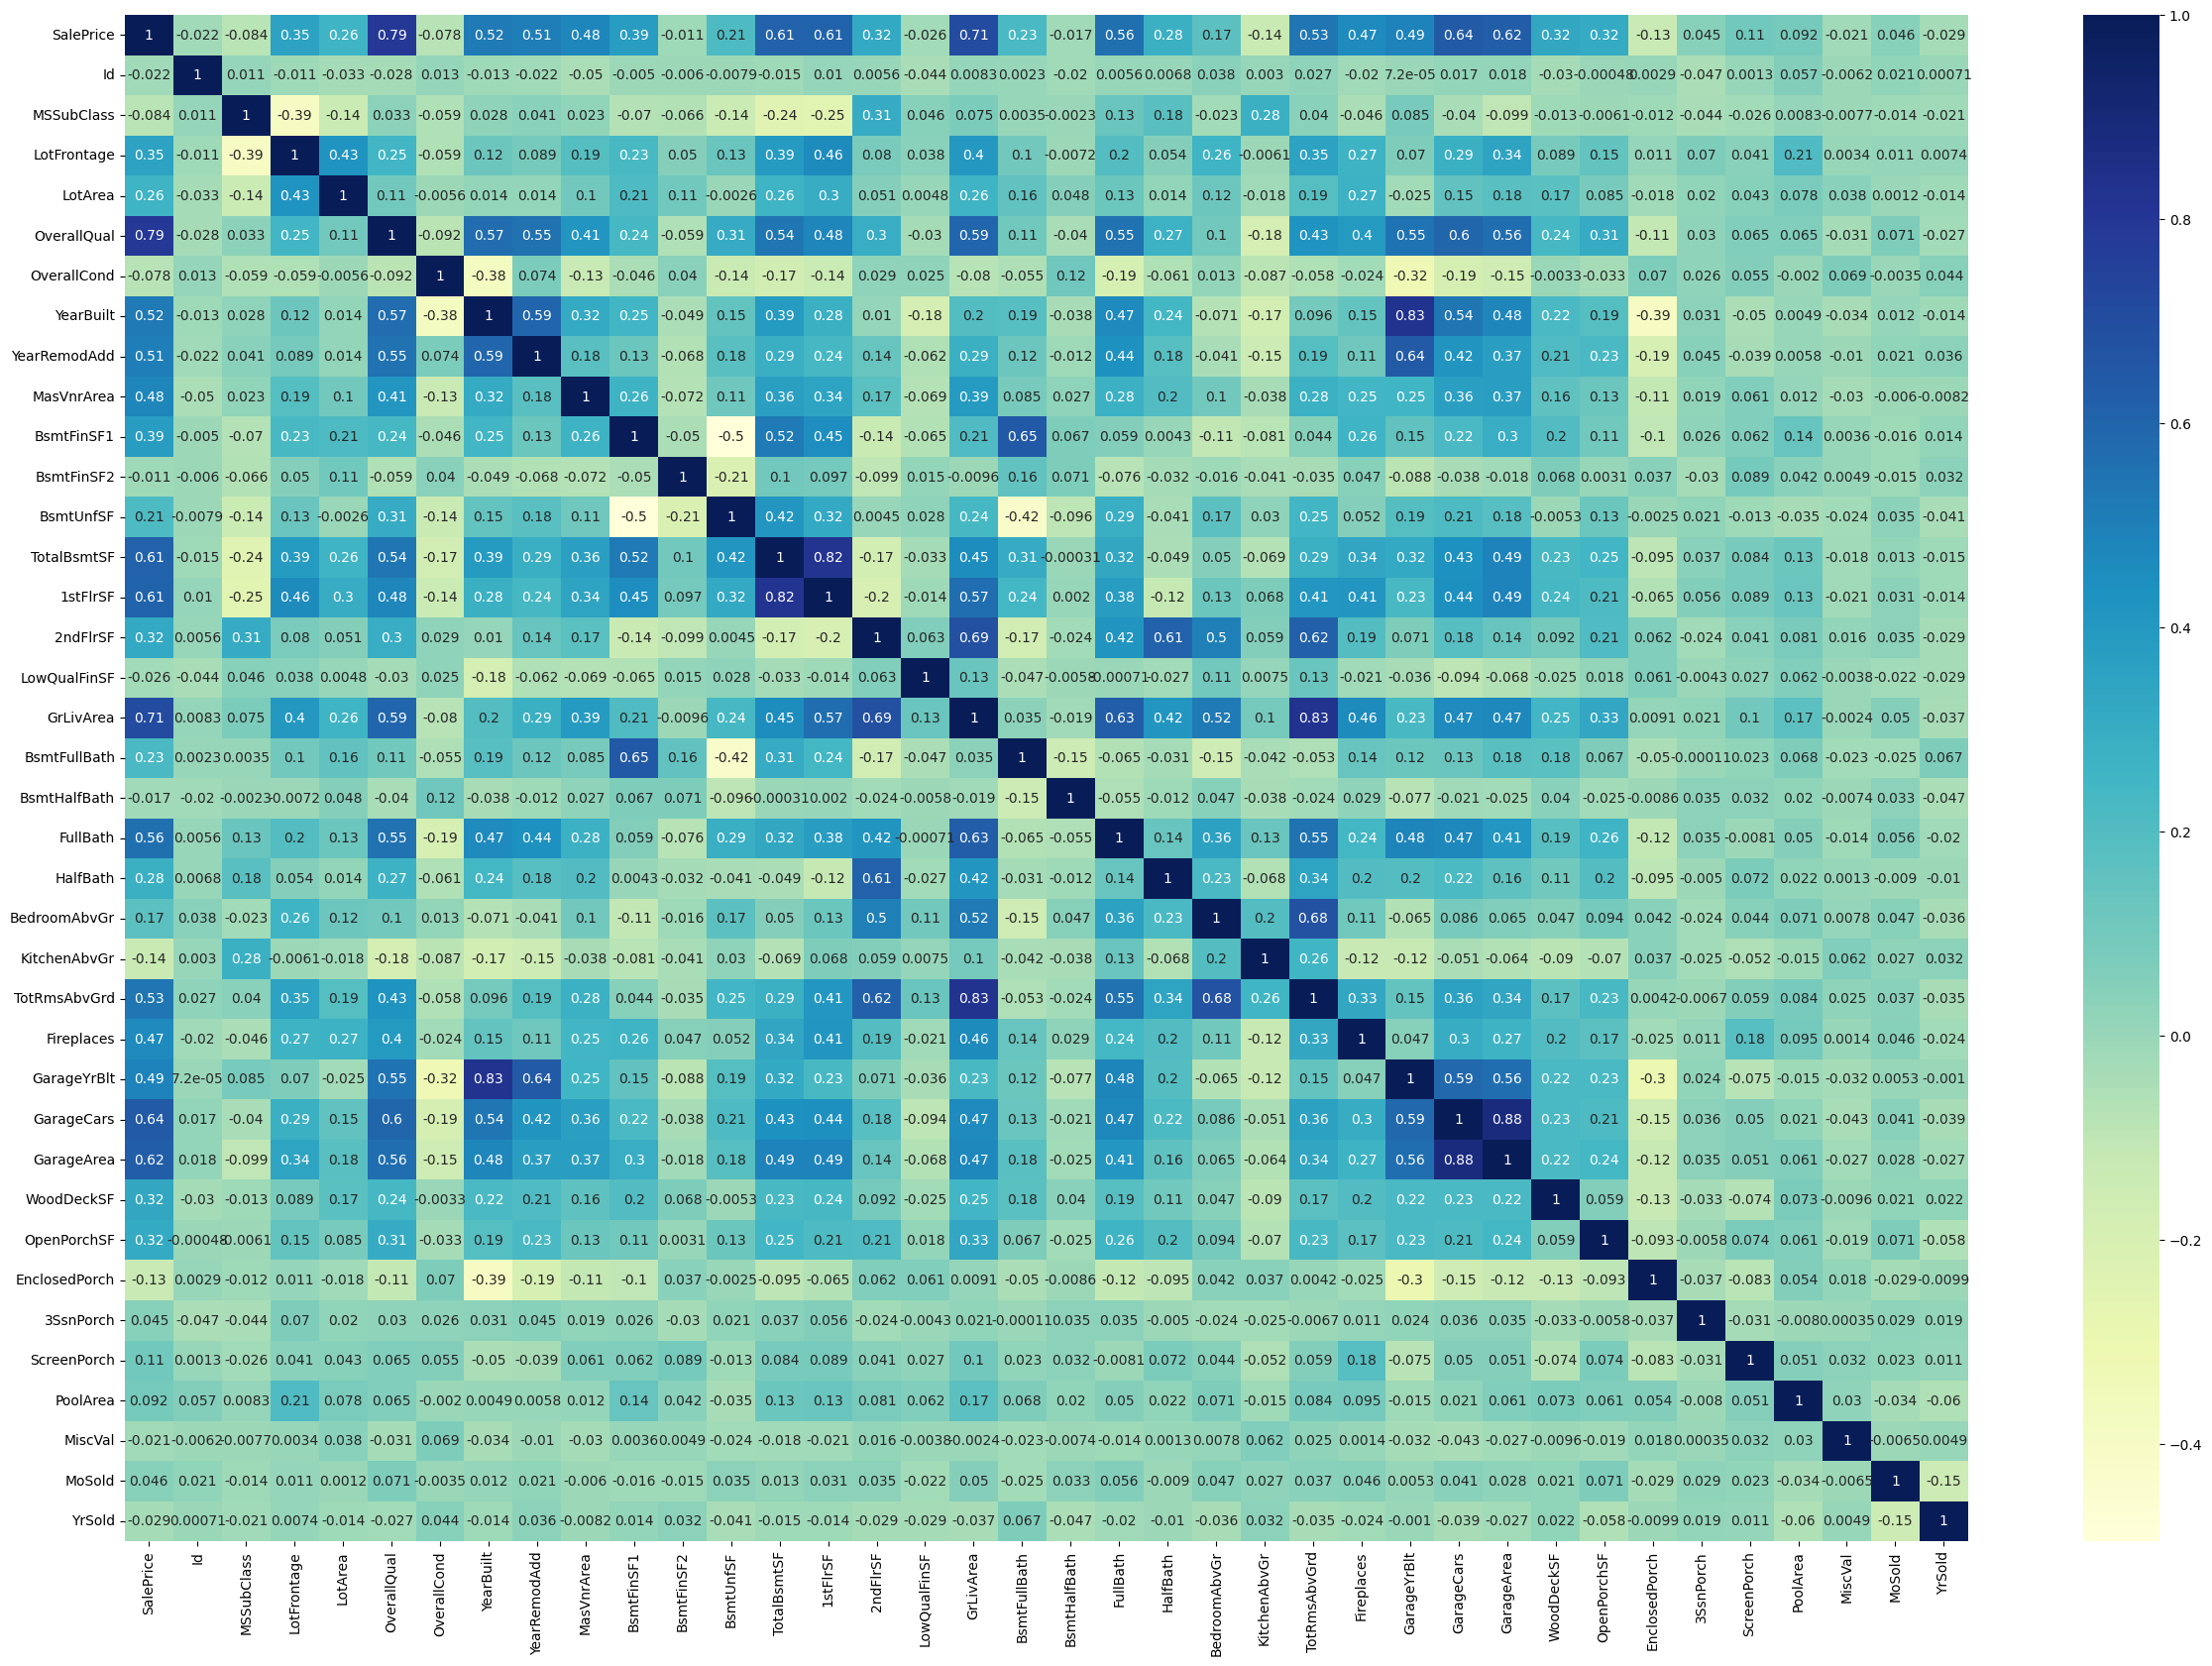

In [9]:
plt.figure(figsize=(30,20))
sns.heatmap(corr_train, cmap='YlGnBu',annot=True)

4) Yukarıdaki korelasyon işlemlerinden sonra kolonlardaki aşağıdaki düzenlemeler yapılarak temizlik yapılır

In [10]:
ev_train1 = ev_train_original[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt','MasVnrArea','SalePrice']]
ev_train = ev_train1.dropna(axis=0)
ev_train.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,SalePrice
0,7,1710,2,548,856,856,2,8,2003,2003,2003.0,196.0,208500
1,6,1262,2,460,1262,1262,2,6,1976,1976,1976.0,0.0,181500
2,7,1786,2,608,920,920,2,6,2001,2002,2001.0,162.0,223500
3,7,1717,3,642,756,961,1,7,1915,1970,1998.0,0.0,140000
4,8,2198,3,836,1145,1145,2,9,2000,2000,2000.0,350.0,250000


 5)Train verisi X ve y olmak üzere iki ayrı değişkene atama yapılır  

In [11]:
X = ev_train[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt','MasVnrArea']]
y = ev_train[['SalePrice']]

6) Scatter grafikleriyle x ve y arasındaki korelasyonu gösterebiliriz;

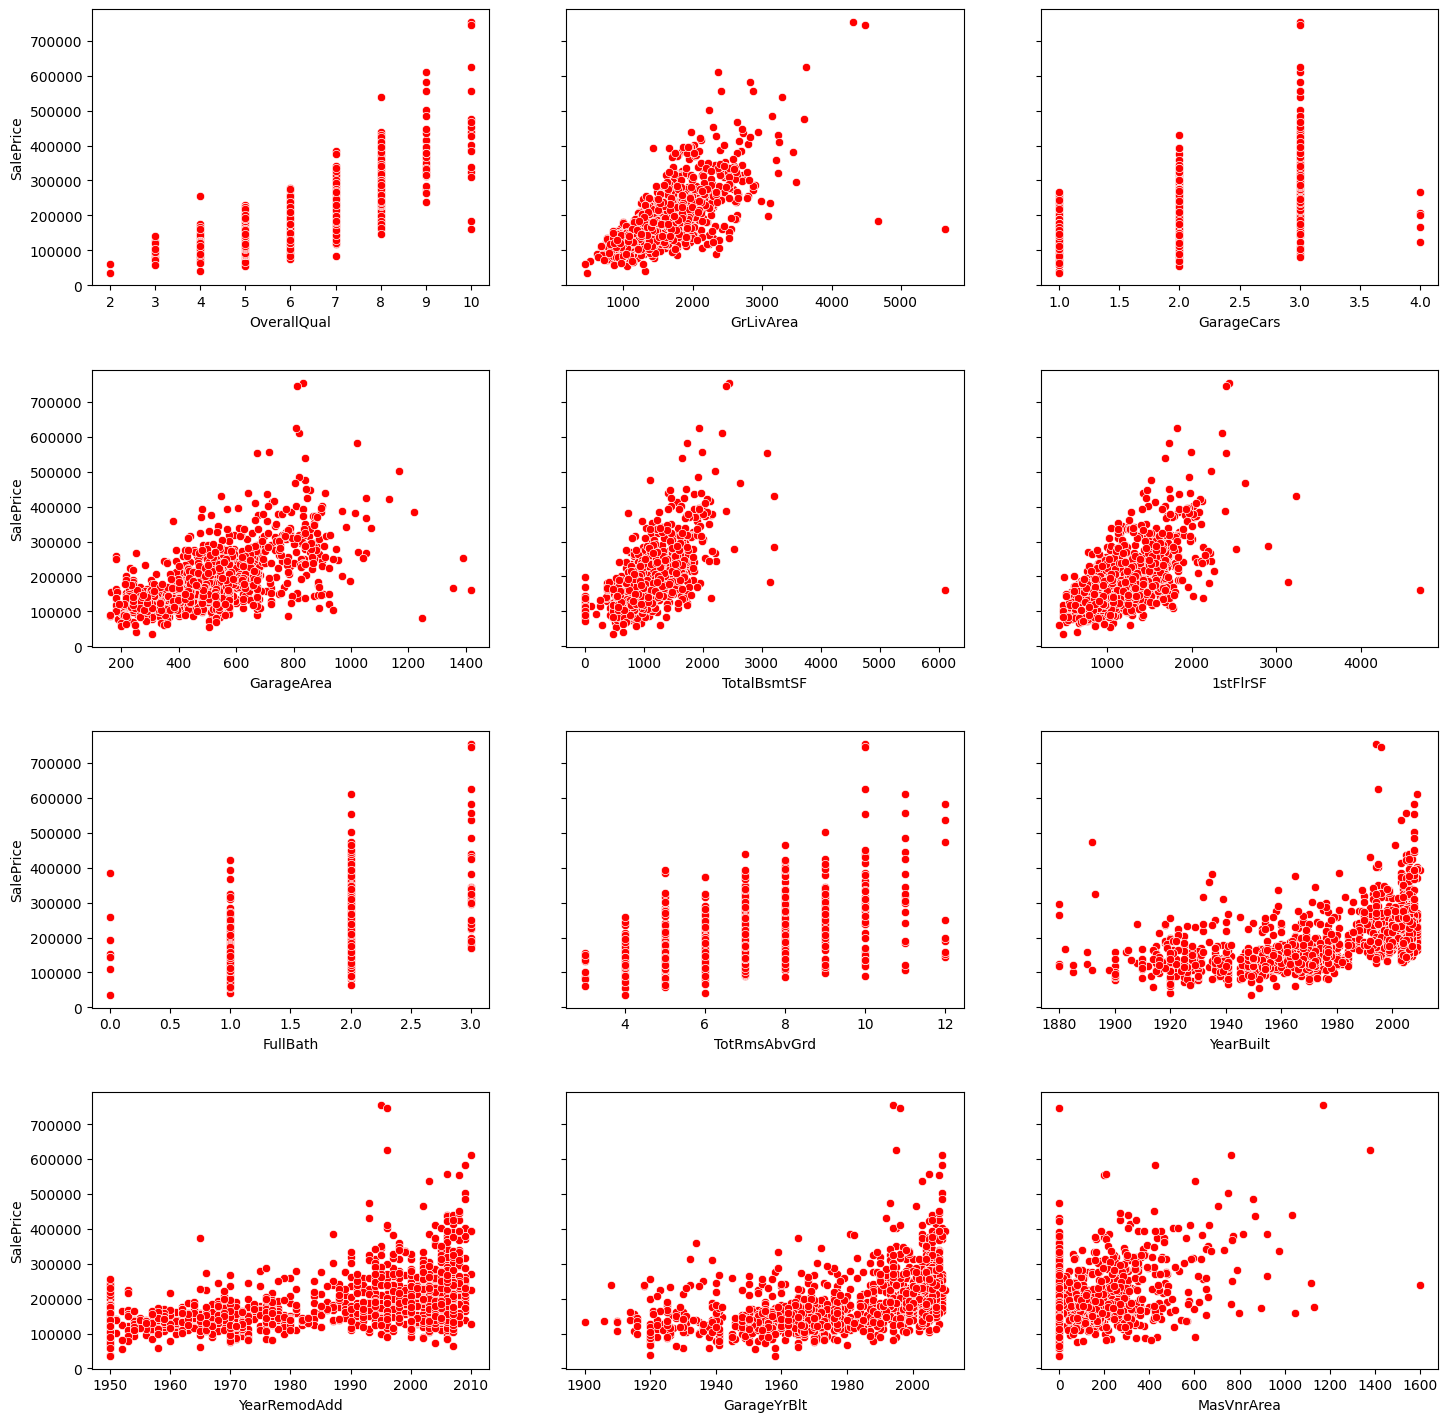

In [12]:
fig, axs = plt.subplots(nrows=4, ncols=3, sharey= True, figsize=(15,15))
fig.tight_layout(pad=4.0)

axs = axs.flatten()

for i in enumerate(X):
    sns.scatterplot(ev_train, x = i[1], y="SalePrice", ax = axs[i[0]], color = 'red')

7) Kolonlar daha detaylı bir şekilde incelenir;

*  OverallQual

In [13]:
OverallQual = ev_train[['OverallQual']]
OverallQual.describe()

,OverallQual
count,1371.000000
mean,6.180890
std,1.344125
min,2.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,10.000000


> Boxplot grafiği çizilir

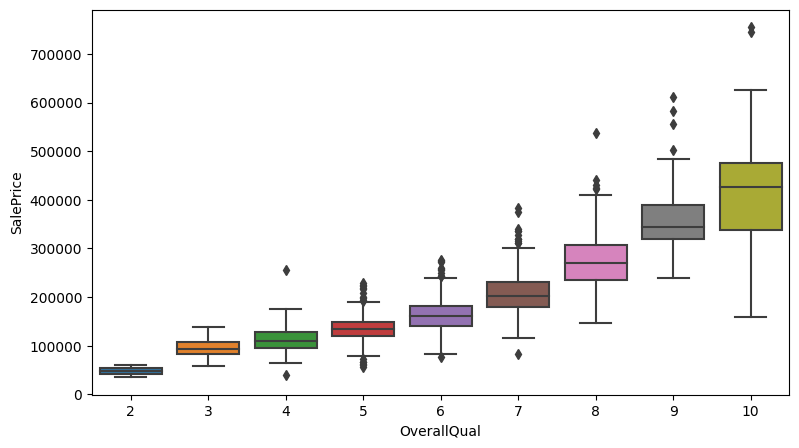

In [14]:
fig, axes = plt.subplots(figsize = (9,5))
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = ev_train)
plt.show()

> Buradaki rakamların anlamları şu şekildedir;

OverallQual: Rates the overall material and finish of the house 

10 Very Excellent 

9 Excellent

8 Very Good 

7 Good 

6 Above Average 

5 Average 

4 Below Average 

3 Fair 

2 Poor 

1 Very Poor


tüm bu datalara bakarak malzemeye bakıldığında fiyatla orantılı arttığını görebiliriz, özellikle 8 ve 10 değerler arasındakilerin diğerlerine göre daha yüksek potansiyelli olduğunu söyleyebiliriz. Ayrıca 4 altındakilerin de yine çok düşük bir potansiyeli olmadığını görebiliriz

* GrLivArea ; Zemin üstündeki yaşam alanı metrekaresi

In [15]:
GrLivArea = ev_train[['GrLivArea']]
GrLivArea.describe()

,GrLivArea
count,1371.000000
mean,1533.348651
std,519.313228
min,438.000000
25%,1152.000000
50%,1479.000000
75%,1788.000000
max,5642.000000


> Scatterplot grafiğini çizebiliriz

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

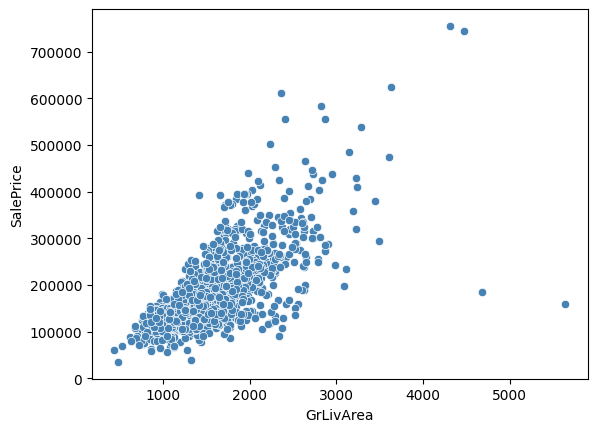

In [16]:
sns.scatterplot(data = ev_train, x = 'GrLivArea', y = 'SalePrice', color = 'steelblue')

Grafiğe bakılarak evin metrekaresi arttıkça fiyatının da arttığını rahatlıkla görebiliriz.Ama 4000 küsürden sonraki yerlerde fiyatın ani düşüş gösterdiğini ve 200bin doların altına indiğini görebiliriz. Ayrıca, en fazla 4. en büyük metrekareli alanın yüksek tutara sahip olduğunu görebiliyoruz

* GarageCars : Garajın Araba Kapasitesi

In [17]:
GarageCars = ev_train[['GarageCars']]
GarageCars.describe()

,GarageCars
count,1371.000000
mean,1.869438
std,0.631086
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,4.000000


BoxPlot grafiğin çizdirmek istersek;

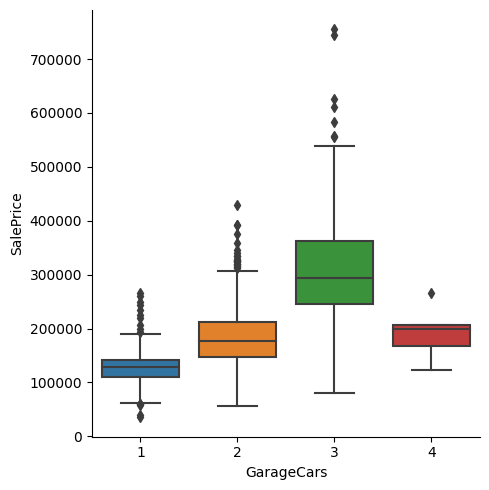

In [18]:
sns.catplot(data = ev_train, x = 'GarageCars', y = 'SalePrice', kind= 'box')

En fazla fiyatın 3 arabalı garajların yüksek fiyata sahip olduğunu görüyoruz, 4 araçlı garajların fiyatı 2 arabalı garajlı evden biraz daha düşük olduğunu ve tek araç kapasiteli garajdan yüksek olduklarını görebiliriz

* GarageArea : Garaj metrekaresi

In [19]:
GarageArea = ev_train[['GarageArea', 'SalePrice']]
GarageArea.describe()

,GarageArea,SalePrice
count,1371.000000,1371.000000
mean,500.389497,185181.890591
std,185.939979,78872.352654
min,160.000000,35311.000000
25%,378.000000,133950.000000
50%,484.000000,167000.000000
75%,582.500000,217750.000000
max,1418.000000,755000.000000


> Scatterplot grafiği şu şekildedir;

<AxesSubplot: xlabel='GarageArea', ylabel='SalePrice'>

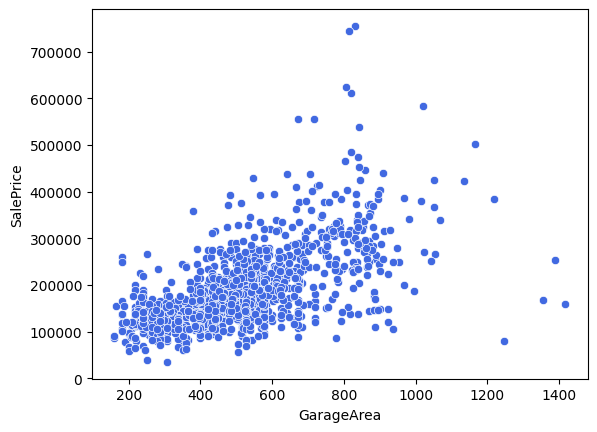

In [20]:
sns.scatterplot(data = ev_train, x ='GarageArea', y= 'SalePrice', color = 'Royalblue')

Bu grafikten çok fazla bağlantılı bir ilişki olduğunu çok fazla söyleyemeyiz


* * Cluster'ları bulma yöntemi;

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4 , init = 'k-means++')
kmeans.fit(GarageArea)

KMeans(n_clusters=4)

Text(0, 0.5, 'Inertia')

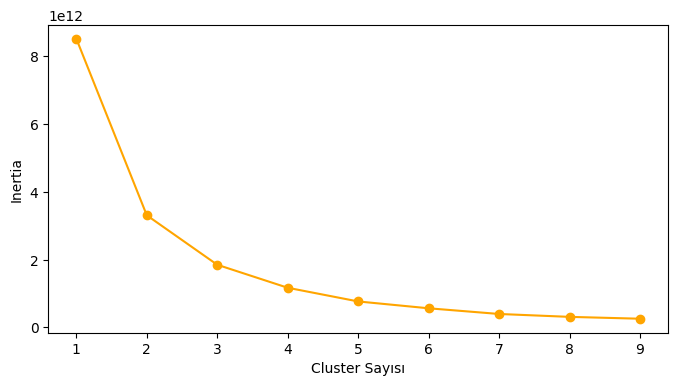

In [22]:
#Multiple K-means algoritmasını fit ederek, değerleri boş liste içine sıralarız
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++')
    kmeans.fit(GarageArea)
    SSE.append(kmeans.inertia_)
    
#Sonucları dataframe'e cevirip grafiğini cizdirme

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize = (8,4))
plt.plot(frame['Cluster'], frame['SSE'], marker = 'o', color='orange')
plt.xlabel('Cluster Sayısı')
plt.ylabel('Inertia')

3 ve 5 arasındaki clusterları seçebiliriz. Cluster sayısını 4 olarak ayarlayıp modeli fit edelim;

In [23]:
K = 4
Centroids = (ev_train.sample(n=K))

In [24]:
diff =1
i = 0

while(diff!= 0):
    j = 1
    for index1, rc in Centroids.iterrows():
        ED = []
        for index2, rd in ev_train.iterrows():
            d1 = (rc['GarageArea'] - rd['GarageArea'])**2
            d2 = (rc['SalePrice'] - rd['SalePrice'])**2
            d = np.sqrt(d1+d2)
            ED.append(d)
        ev_train[j] = ED
        j+=1
        
    C = []
    for index, r in ev_train.iterrows():
        min_dist = r[1]
        p = 1
        for j in range(K):
            if r[j+1] < min_dist:
                min_dist = r[j+1]
                p = j+1
        C.append(p)
    ev_train['Cluster'] = C
    Centroids2 = ev_train.groupby(['Cluster']).mean()[['SalePrice', 'GarageArea']]
    if i == 0:
        diff = 1
        i = i +1
    else:
        diff = (Centroids2['SalePrice'] - Centroids['SalePrice']).sum() + (Centroids2['GarageArea'] - Centroids['GarageArea']).sum()
        print(diff.sum())
    Centroids = ev_train.groupby(['Cluster']).mean()[['SalePrice','GarageArea']]
            

26808.39590493913
24514.824987752447
22579.512371816178
20575.857231220252
22097.68473388794
21819.114915496164
19227.764590999093
14896.265686079707
14623.094279057292
10534.651542388621
9912.174080023888
8431.425757286037
13689.73854310802
14425.509341523053
14555.440708869604
8862.349410210969
11082.430968225346
10667.917595450805
7215.9244648300755
4625.095315184364
5238.7178197654675
1511.2886340385678
3497.4037908048085
1308.1407964372486
385.96354061548067
1609.563738404127
2326.512186362516
860.7797121203063
678.0985806262051
848.012755820573
0.0


Yukarıdaki kodda, k-ortalama (k-means) algoritması uygulanarak ev fiyatları ve garaj alanları verileri kullanılarak evlerin belirli sayıda kümeye bölünmesi amaçlanmıştır. Algoritma, öncelikle belirli sayıda (K) rastgele centroid noktası seçiyor. Daha sonra, tüm veri noktaları ile her bir centroid arasındaki öklid uzaklığı hesaplanarak, en yakın centroidun hangisi olduğunu belirleyen bir etiket (cluster) atanıyor. Sonra, her bir kümenin ortalaması alınarak yeni centroid noktaları oluşturuluyor. Bu yeni centroidlar, veriler tekrar kümelendirilene kadar önceki centroidlardan farklı olana kadar döngü içinde hesaplanıyor. Bu iterasyonlar, centroidların hareketini azaltarak kümeleme sonuçlarının daha iyi olmasını sağlıyor.

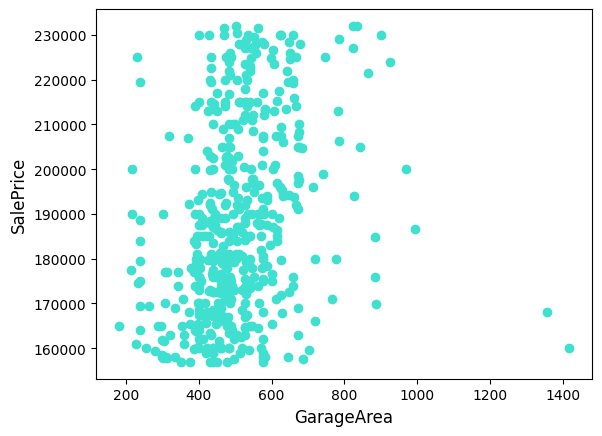

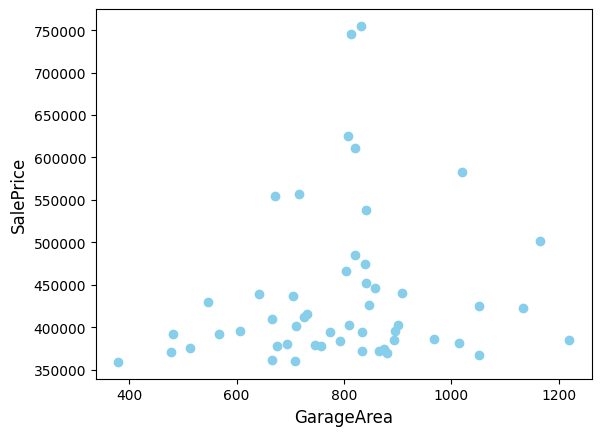

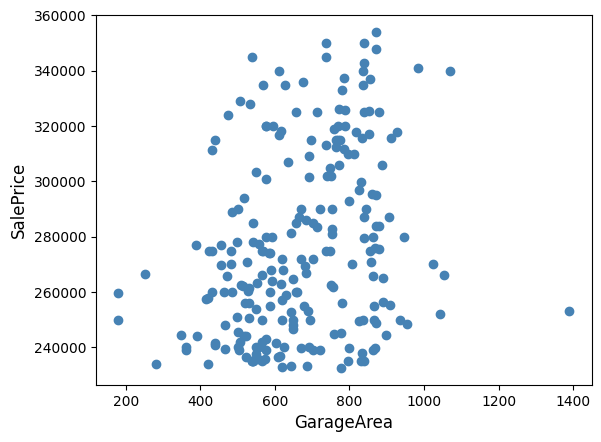

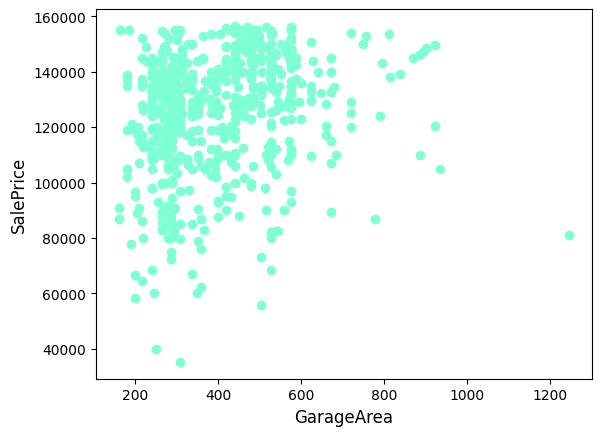

In [25]:
color1 = ['turquoise','skyblue', 'steelblue', 'aquamarine']
for k in range(K):
    data = ev_train[ev_train['Cluster']== k + 1]
    plt.scatter(data['GarageArea'], data['SalePrice'], c= color1[k])
    
    plt.xlabel('GarageArea' , fontsize =12)
    plt.ylabel('SalePrice', fontsize =12)
    plt.show()

Eğer hepsini birlikte gösterirsek, Clusterların ayrı ayrı 4 bölgede nasıl göründüğünü daha iyi ayırt edebiliriz

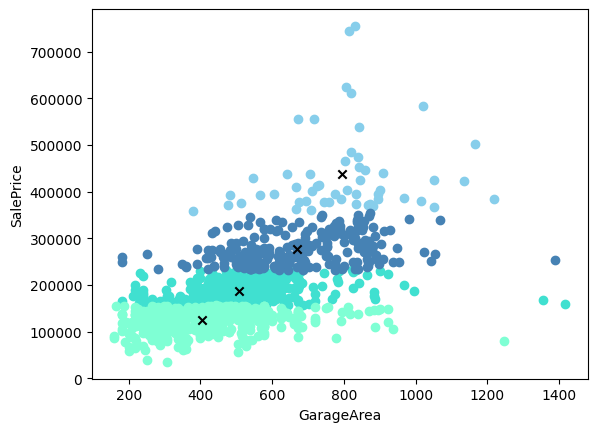

In [26]:
color1 = ['turquoise','skyblue', 'steelblue', 'aquamarine']
for k in range(K):
    data = ev_train[ev_train['Cluster']== k + 1]
    plt.scatter(data['GarageArea'], data['SalePrice'], c= color1[k])
plt.scatter(Centroids["GarageArea"],Centroids["SalePrice"],c='black', marker = 'x')
plt.xlabel('GarageArea', fontsize=10)
plt.ylabel('SalePrice', fontsize=10)
plt.show()

In [27]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(GarageArea)
GarageArea_section = kmeans.predict(GarageArea)

In [28]:
#Her değerin uniq olarak değerini al ve hepsini say
unique, counts = np.unique(GarageArea_section, return_counts = True)
#bunları tek tek göster
print(np.asarray((unique, counts)))

[[  0   1   2   3]
 [ 52 604 228 487]]


Yukarıdaki Cluster grafiklerinden de anlaşılacağı üzere büyük garajların yüksek fiyatları olduğunu görebiliyoruz. 400 ve 500 arasındaki metrekarelerin fiyatta büyük bir oynama yapmadığını görebiliriz. 680 metrekareden yukarısında, fiyatta büyük farklar oluşmaktadır

> TotalBsmtSF: Bodrum alanının toplam metrekaresi

In [29]:
TotalBsmtSF = ev_train[['TotalBsmtSF']]
TotalBsmtSF.describe()

,TotalBsmtSF
count,1371.000000
mean,1072.869438
std,435.797686
min,0.000000
25%,808.000000
50%,1008.000000
75%,1314.000000
max,6110.000000


Bunun scatterplotu şu şekilde olacaktır

<AxesSubplot: xlabel='TotalBsmtSF', ylabel='SalePrice'>

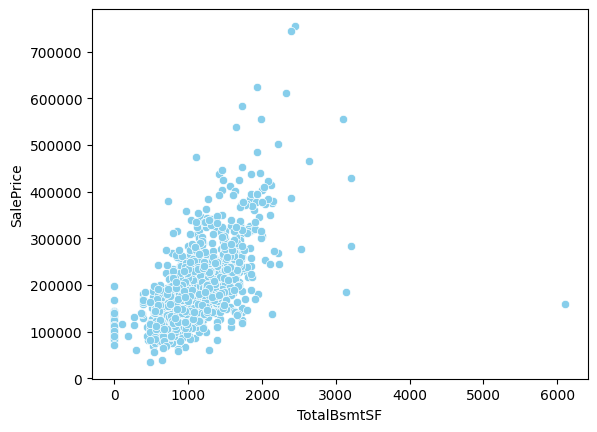

In [30]:
sns.scatterplot(data = ev_train, x = 'TotalBsmtSF', y = 'SalePrice',color='skyblue')

Grafikten de görüleceği üzere ne kadar çok bodrum alanı büyük olursa fiyat da o kadar artıyor ama 3000 metrekaredeki evlerin fiyatların istisna düşüşler görebiliyoruz aynı şekilde 6000'ı geçen bir tane evde de fiyatın 200000'nin altına düştüğünü söyleyebiliriz

> 1stFlrSF: İlk katın alanı

In [31]:
firstSF = ev_train[['1stFlrSF']]
firstSF.describe()

,1stFlrSF
count,1371.000000
mean,1175.778264
std,385.409660
min,438.000000
25%,894.000000
50%,1098.000000
75%,1414.000000
max,4692.000000


Bu değişkenin satış fiyatıyla olan scatterplot grafiği ise şu şekildedir;

<AxesSubplot: xlabel='1stFlrSF', ylabel='SalePrice'>

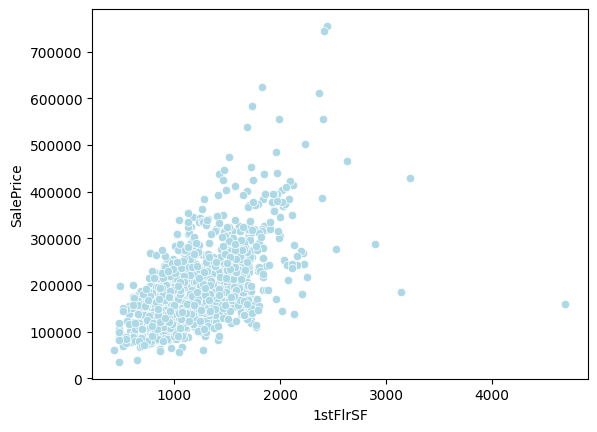

In [32]:
sns.scatterplot(data = ev_train, x='1stFlrSF', y='SalePrice', color= 'lightblue')

Bodrum metrekaresiyle aynı özelliklere sahip olduğunu söyleyebiliriz. 2500 metrekareden sonra fiyatın düştüğünü ve 6000 civarındaki bir evde ise 200000 doların altına indiğini görebiliriz

> FullBath: Tüm banyolar

In [33]:
fullbath = ev_train[['FullBath']]
fullbath.describe()

,FullBath
count,1371.000000
mean,1.577681
std,0.547374
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,3.000000


Banyoların fiyatla olan ilişkisini boxplot ile gösterebiliriz;

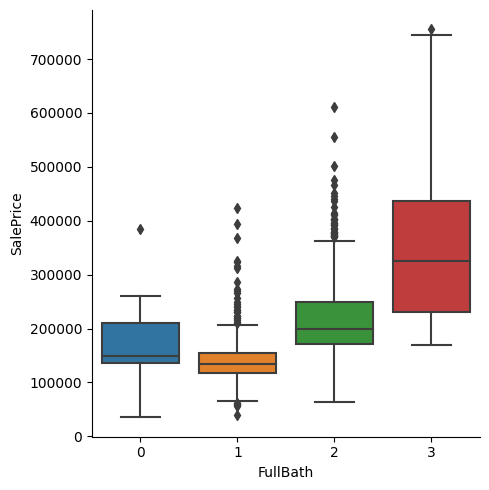

In [34]:
sns.catplot(data =ev_train, x='FullBath', y='SalePrice', kind='box')

En düşük fiyatın 1 banyolu olması, hiç banyo olmayışından daha düşük fiyatta olması ilginç bir özellik olarak görünüyor. 3 banyolu olan evin 2 banyoludan açık ara daha fazla fiyata sahip olduğunu söyleyebliriz.

> TotRmsAbvGrd : Banyo dışındaki tüm odalar

In [35]:
rooms = ev_train[['TotRmsAbvGrd']]
rooms.describe()

,TotRmsAbvGrd
count,1371.000000
mean,6.552152
std,1.590350
min,3.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,12.000000


Oda sayılarının ev fiyatıyla olan ilişkisini boxplot ile gösterirsek şu şekilde olacaktır;

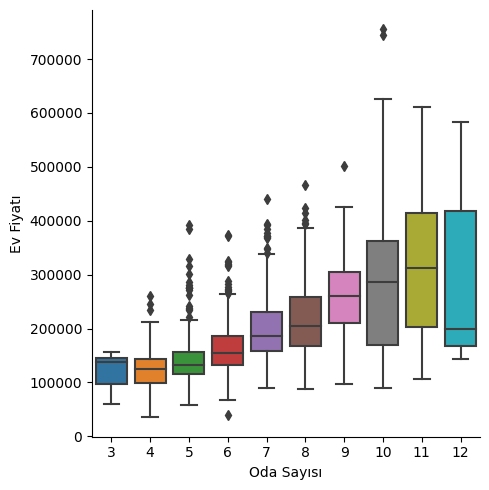

In [36]:
sns.catplot(data = ev_train, x='TotRmsAbvGrd', y='SalePrice', kind='box')
plt.xlabel('Oda Sayısı')
plt.ylabel('Ev Fiyatı')
plt.show()

En geniş fiyat aralığı 10 odalı evlerde vardır. En az 3 odalı evlerle datamızın grafiği başlıyor en fazla 12 odalı olarak bitiyor. 3 ve 4 odalıların fiyat ortalamaları neredeyse eşit ama 4 odalının daha fazla fiyat aralığı bulunuyor. 5 odalı da 4 olandan biraz daha fazla. Sonrasında 10 odalıya kadar neredeyse doğrusala yakın şekilde bir artış görülürken, 11 ve 12 odalıların neredeyse eşit fiyatlarda oldunu hatta 12 odalılarda fiyatların düşmeye başladığını görebiliyoruz.

>YearBuilt: Yapım yılı

In [37]:
year = ev_train[['YearBuilt']]
year.describe()

,YearBuilt
count,1371.000000
mean,1972.808169
std,29.374036
min,1880.000000
25%,1955.000000
50%,1975.000000
75%,2001.000000
max,2010.000000


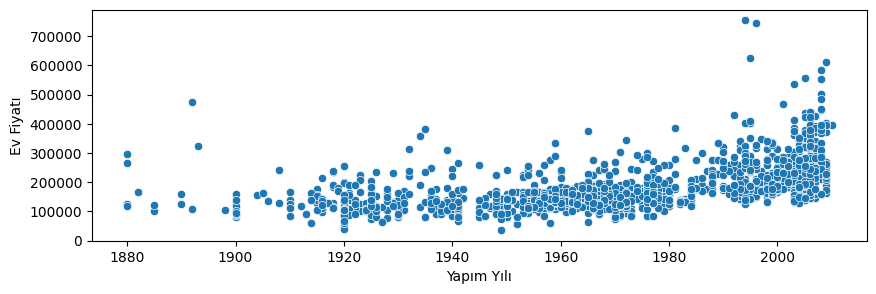

In [38]:
fig, axes = plt.subplots(figsize= (10,3))
sns.scatterplot(data = ev_train, x='YearBuilt' , y= 'SalePrice')
plt.xlabel('Yapım Yılı')
plt.ylabel('Ev Fiyatı')
plt.show()

Yılların artışı fiyatları çok etkilemiş görünmüyor ama 1980 lerden sonra fiyatlardaki artışın büyüdüğünü söyleyebiliriz

>YearRemodAdd: Restorasyon Yılı

In [39]:
remod = ev_train[['YearRemodAdd']]
remod.describe()

,YearRemodAdd
count,1371.000000
mean,1985.342815
std,20.453845
min,1950.000000
25%,1967.500000
50%,1994.000000
75%,2004.000000
max,2010.000000


Text(0, 0.5, 'Ev fiyatı')

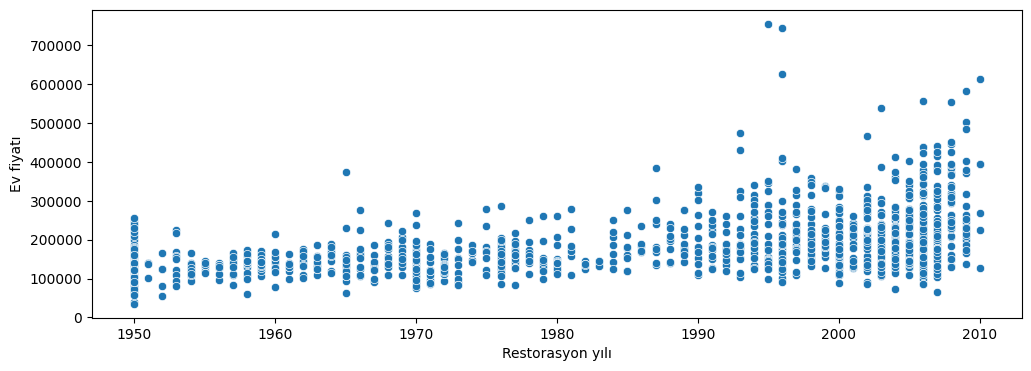

In [40]:
fig, axes = plt.subplots(figsize=(12,4))

sns.scatterplot(data =ev_train, x = 'YearRemodAdd', y='SalePrice')
plt.xlabel('Restorasyon yılı')
plt.ylabel('Ev fiyatı')

Buradaki restorasyon yılının satış fiyatını etkilemediğini görebiliyoruz fakat 1995 yılında restore edilen bazı evlerin en yüksek fiyata sahip olduğunu ve sonrasındaki yıllarda normal bir artış seyri olduğunu söyleyebiliriz

> GarageYrBlt: Garaj yapım yılı

In [41]:
grg = ev_train[['GarageYrBlt']]
grg.describe()

,GarageYrBlt
count,1371.000000
mean,1978.374179
std,24.688912
min,1900.000000
25%,1961.000000
50%,1980.000000
75%,2002.000000
max,2010.000000


Text(0, 0.5, 'Ev Fiyatı')

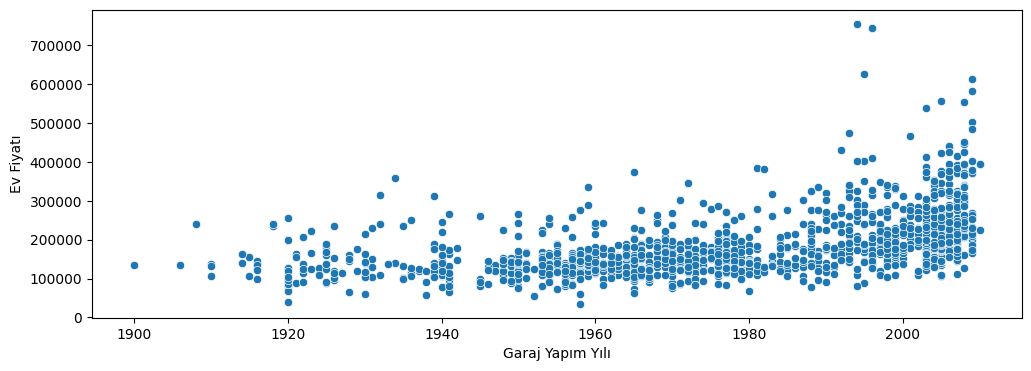

In [42]:
fig, axes = plt.subplots(figsize= (12,4))
sns.scatterplot(data =ev_train, x='GarageYrBlt', y='SalePrice')
plt.xlabel('Garaj Yapım Yılı')
plt.ylabel('Ev Fiyatı')

2000'lerin sonuna kadar garaj yapım yılının ev fiyatını etkilemediğini görebiliyoruz. Ayrıca yine 2000lerin sonlarına gelmeden yapılan garajlı evlerin en yüksek fiyatta olduğunu ve 2000'den sonra yapılanların bariz şekilde yükseldiğini söyleyebiliriz

> MasVnrArea : Kaplama Duvar alanı

In [43]:
masvnr = ev_train[['MasVnrArea']]
masvnr.describe()

,MasVnrArea
count,1371.000000
mean,108.997082
std,184.545459
min,0.000000
25%,0.000000
50%,0.000000
75%,171.500000
max,1600.000000


Text(0, 0.5, 'Ev fiyatı')

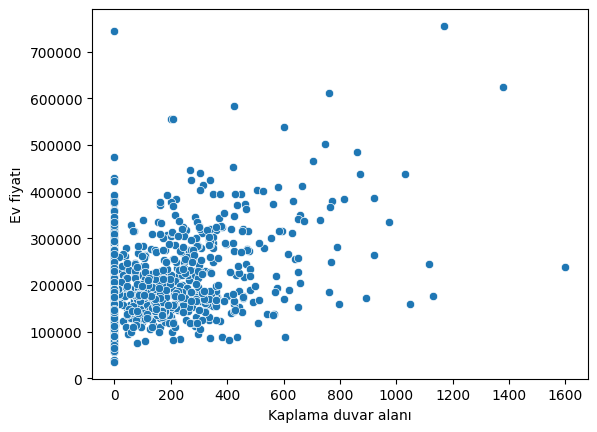

In [44]:
sns.scatterplot(data=ev_train, x= 'MasVnrArea', y='SalePrice')
plt.xlabel('Kaplama duvar alanı')
plt.ylabel('Ev fiyatı')

Evdeki duvar kaplamasının ne kadar az olursa ev fiyatının o kadar fazla olduğunu görebiliyoruz. Bunun dışında istisna bir veri olarak 1200 metrekarelik duvar kaplaması olan bir evin en yüksek tutarda bir ev fiyatı verisi olduğunu söyleyebiliriz

# Tahminler: Linear Regresyon ve Xgboost regresyonu

Train setimizi analiz ettikten sonra, xgboost regresyonunu kullanarak ev satış fiyatını tahmin etmeye geçebiliriz

Eğer nan bir değer varsa diye kontrol için şu şekilde ilerleyebiliriz

In [45]:
X.isna().sum()

OverallQual     0
GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
GarageYrBlt     0
MasVnrArea      0
dtype: int64

Herhangi bir Nan değeri bulunmadığını teyit etmiş olduk. X ve y'nin shape'lerini öğrenmek istersek;

In [46]:
print(X.shape)

(1371, 12)


In [47]:
print(y.shape)

(1371, 1)


In [48]:
print('Train örnek sayısı:', len(X))

Train örnek sayısı: 1371


1371 adet örnek train datasına bölme işlemi uygulanır;

In [49]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.3, random_state = 2)
print(X_train.shape, X_val.shape,y_train.shape, y_val.shape)

(959, 12) (412, 12) (959, 1) (412, 1)


Aşağıdaki kod bloğunda oluşturulan "xgb1" nesnesi, XGBoost algoritmasının temel yapılandırmasını temsil eder. "verbosity" parametresi, modelin ne kadar ayrıntılı çıktılar oluşturacağını belirler. Burada "0" seviyesi, sadece hata mesajları gibi önemli çıktıları gösterir.

"fit" fonksiyonu, verileri kullanarak modeli eğitir. Bu işlem, "X_train" ve "y_train" verilerinin "xgb1" modeline beslenerek gerçekleştirilir. Bu şekilde, model öğrenir ve eğitim verilerine uydurulur. Sonrasında model, tahminler yapmak için kullanılır.

In [50]:
import xgboost as xgb

xgb1 = xgb.XGBRegressor(verbosity=0)
print(xgb1)

xgb1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Şimdi de aşağıdaki, "xgboost" kütüphanesi kullanarak oluşturulan bir makine öğrenimi modelinin eğitim verileri üzerindeki performansını değerlendirmektedir.

"xgb1.score(X_train, y_train)" fonksiyonu, modelin eğitim verileri üzerindeki doğruluğunu hesaplar ve "score" değişkenine atar. Bu fonksiyon, modelin doğruluğunu hesaplamak için verilen X_train ve y_train verilerini kullanır.

In [51]:
score = xgb1.score(X_train, y_train)
print('Training score:', score)

Training score: 0.9991408621434525


Aşağıdaki kod bloğu, "scikit-learn" kütüphanesinin "metrics" modülünden "mean_squared_error" fonksiyonunu kullanarak, XGBoost regresyon modelinin tahminlerinin gerçek değerlerden ne kadar uzak olduğunu ölçer.

"xgb1.predict(X_val)" ifadesi, XGBoost modelinin, "X_val" veri setindeki özelliklere dayanarak hedef değişkenlerin tahminlerini yapmasını sağlar. "y_pred" değişkeni, bu tahminlerin tutulduğu bir vektördür.

"mean_squared_error(y_val, y_pred)" fonksiyonu, gerçek hedef değerleri ("y_val") ve XGBoost modelinin tahmin ettiği hedef değerleri ("y_pred") kullanarak, ortalama kare hatasını (MSE) hesaplar. MSE, tahminlerin gerçek değerlerden ne kadar uzak olduğunu ölçer. Daha düşük MSE değerleri, daha iyi bir tahmin performansı gösterir.

"print("MSE: %.2f" % means)" ifadesi, hesaplanan MSE değerini ekrana yazdırır. "%.2f" ifadesi, MSE değerinin ondalık kısmını iki basamakla sınırlar.

"print("RMSE: %.2f" % (means**(1/2.0)))" ifadesi, hesaplanan MSE değerinin karekökünü (RMSE) hesaplar ve ekrana yazdırır. "%.2f" ifadesi, RMSE değerinin ondalık kısmını iki basamakla sınırlar.

In [52]:
from sklearn.metrics import mean_squared_error

y_pred = xgb1.predict(X_val)
means = mean_squared_error(y_val, y_pred)

In [53]:
print("MSE: %.2f" % means)
print("RMSE: %.2f" % (means**(1/2.0)))

MSE: 1315950075.08
RMSE: 36276.03


Şimdi gerçek ve tahmin edilen hedef değişkenlerin doğruluğunu görselleştirelim.

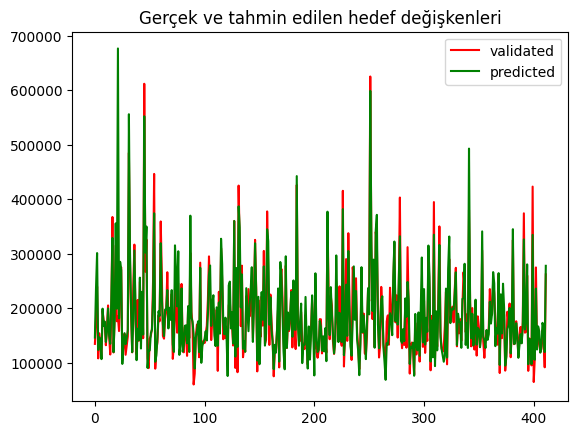

In [54]:
x_ax = range(len(y_val))
plt.plot(x_ax, y_val, label='validated', color='red')
plt.plot(x_ax, y_pred, label='predicted', color='green')
plt.title('Gerçek ve tahmin edilen hedef değişkenleri')
plt.legend()

Şimdi de Linear Regresyon ile sonuçları görelim;

In [55]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

Doğrusal regresyon modelindeki bağımsız değişken sayısı;

In [56]:
a = linear_model.intercept_
b = linear_model.coef_
print(a,b)
print('bshape:',b.shape)

[-1010588.13549834] [[ 2.09734891e+04  5.65426593e+01  1.48358585e+04  6.65057912e+00
   1.28212852e+01  1.74061362e+01 -5.97688771e+03 -1.54797459e+03
   2.94796439e+02  3.24000190e+02 -1.48143539e+02  2.19606548e+01]]
bshape: (1, 12)


In [57]:
y_pred_linear = linear_model.predict(X_val)
means_linear = mean_squared_error(y_val, y_pred_linear)

print('MSE:',means_linear)
print('RMSE:',means_linear**(1/2.0))

MSE: 1281472294.9693003
RMSE: 35797.65767434093


Yukarıdaki bu kod bloğu, "scikit-learn" kütüphanesi kullanarak yapılan doğrusal regresyon modeli ("linear_model") ile "X_val" verileri üzerinden tahmin edilen hedef değişkenleri ("y_pred_linear") ve bu tahminlerin gerçek hedef değişkenleri ("y_val") ile karşılaştırılması sonucu hesaplanan ortalama karesel hata ("mean_squared_error") değerini ekrana yazdırır.

"y_pred_linear = linear_model.predict(X_val)" ifadesi, doğrusal regresyon modelinin "X_val" verileri üzerinden tahmin ettiği hedef değişkenlerinin ("y_pred_linear") hesaplanmasını sağlar.

"means_linear = mean_squared_error(y_val, y_pred_linear)" ifadesi, gerçek hedef değişkenleri ("y_val") ve doğrusal regresyon modelinin tahmin ettiği hedef değişkenleri ("y_pred_linear") arasındaki ortalama karesel hatayı ("mean_squared_error") hesaplar ve "means_linear" değişkenine atar.

"print('MSE:',means_linear)" ifadesi, hesaplanan ortalama karesel hata değerini ekrana yazdırır.

"print('RMSE:',means_linear**(1/2.0))" ifadesi, hesaplanan ortalama karesel hata değerinin karekökünü alarak kök ortalama karesel hatayı ("root mean squared error" ya da "RMSE") hesaplar ve ekrana yazdırır.

Şimdi, doğrusal regresyon modeli ile gerçek ve tahmin edilen hedef değişkenlerinin ("y_val" ve "y_pred_linear") karşılaştırılması sonucu elde edilen grafik görselleştirmesi yapılır.

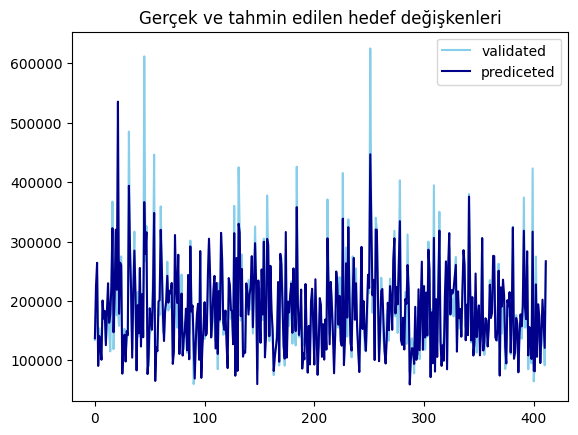

In [58]:
x_ax = range(len(y_val))
plt.plot(x_ax, y_val, label = 'validated',color='skyblue')
plt.plot(x_ax, y_pred_linear, label='prediceted',color='darkblue')
plt.title('Gerçek ve tahmin edilen hedef değişkenleri')
plt.legend()
plt.show()

**Şimde de Random Forest Regresyon modelini uygulayalım;**

Random Forest:
MSE: 1281085411.4552422
RMSE: 35792.25351183189


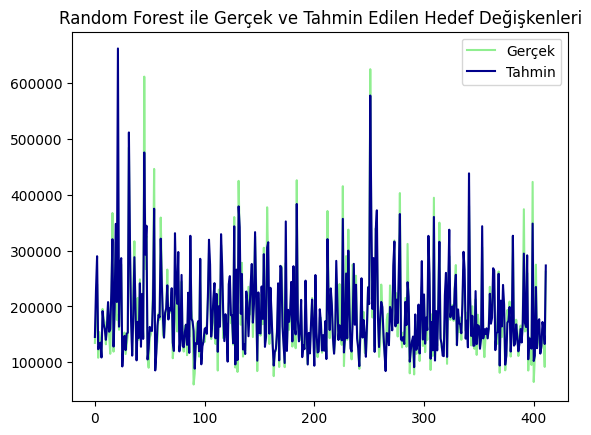

In [59]:
from sklearn.ensemble import RandomForestRegressor

# Model nesnesi oluşturma
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Model eğitimi
rf_model.fit(X_train, y_train)

# Doğrulama verileri üzerinde model performansı ölçümü
y_pred_rf = rf_model.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
print("Random Forest:")
print("MSE:", mse_rf)
print("RMSE:", mse_rf**(1/2.0))

# Tahminlerin gerçek değerlerle karşılaştırılması için grafik gösterimi
x_ax = range(len(y_val))
plt.plot(x_ax, y_val, label='Gerçek', color='lightgreen')
plt.plot(x_ax, y_pred_rf, label='Tahmin', color='darkblue')
plt.title('Random Forest ile Gerçek ve Tahmin Edilen Hedef Değişkenleri')
plt.legend()
plt.show()


**Yapılan tüm modellemeler arasında kullanılması en uygun olarak, RMSE değeri en düşük olarak random forest algoritması seçilmiştir. Şimdi Test datamıza Random forest modelini uygulayalım**

In [60]:
ev_test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Feautre değerlerini train'de seçtiğimiz gibi testte seçelim;

In [61]:
X_test = ev_test_original[['OverallQual','GrLivArea', 'GarageCars', 'GarageArea','TotalBsmtSF', '1stFlrSF', 'FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt','MasVnrArea']]
X_test.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea
0,7,1710,2,548,856,856,2,8,2003,2003,2003.0,196.0
1,6,1262,2,460,1262,1262,2,6,1976,1976,1976.0,0.0
2,7,1786,2,608,920,920,2,6,2001,2002,2001.0,162.0
3,7,1717,3,642,756,961,1,7,1915,1970,1998.0,0.0
4,8,2198,3,836,1145,1145,2,9,2000,2000,2000.0,350.0


In [62]:
X_test.isna().sum()

OverallQual      0
GrLivArea        0
GarageCars       0
GarageArea       0
TotalBsmtSF      0
1stFlrSF         0
FullBath         0
TotRmsAbvGrd     0
YearBuilt        0
YearRemodAdd     0
GarageYrBlt     81
MasVnrArea       8
dtype: int64

In [63]:
X_test2 = X_test.dropna()

Test datamızı da temizledikten sonra artık projenin son adımında modelimizi uygulayabiliriz;

In [64]:
y_test = rf_model.predict(X_test2)

In [65]:
y_test

array([198905.51, 176528.  , 212020.28, ..., 262814.8 , 127599.8 ,
       151421.87])

In [66]:
submission = pd.read_csv('/kaggle/input/regression-technique-eda/House Price Regression Tecnique/sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [67]:
df = pd.DataFrame(y_test)


In [68]:
submission[['SalePrice']] = df
df.head()

,0
0,198905.51
1,176528.00
2,212020.28
3,154407.11
4,269497.90


In [69]:
submission.describe()

,Id,SalePrice
count,1459.000000,1371.000000
mean,2190.000000,186577.613006
std,421.321334,75880.515666
min,1461.000000,50484.930000
25%,1825.500000,135093.300000
50%,2190.000000,167277.000000
75%,2554.500000,220293.950000
max,2919.000000,717250.000000


In [70]:
submission = pd.DataFrame({'Id': submission.Id, 'SalePrice': submission.SalePrice})
submission.to_csv('submission.csv',index = False)

Projenin bu son aşaması, eğitilmiş bir modelin test veri seti üzerinde kullanılarak ev fiyatlarının tahmin edilmesi ve elde edilen tahminlerin bir CSV dosyasına kaydedilmesi ile sonuçlanmıştır. 